# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm
from math import log, e
import random
import sys
import os
import matplotlib.image as mpimg
from IPython.core.display import Image, display
from tqdm import tqdm_notebook
from six.moves import reload_module

### Custom Libraries

In [180]:
from density_tree.decision_tree_create import *
from density_tree.create_data import *
from density_tree.plots import *

# Generic Functions
The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


In [349]:
class Node:
    """
    constructor for new nodes in a density tree.
    """

    def __init__(self):
        # data for node
        self.parent = None  # parent node
        self.split_value = None  # the split value
        self.split_dimension = None  # the split dimension

        # unlabelled data
        self.entropy = None  # entropy, for unlabelled nodes
        self.cov = None  # covariance at node
        self.mean = None  # mean of data points in node
        self.left_entropy = None
        self.right_entropy = None

        # child nodes
        self.left = None  # node to the left, e.g., for value < split_value
        self.right = None

    def get_root(self):
        if self.parent != None:
            return self.parent.get_root()
        else:
            return self

    def has_children(self):
        """print data for node"""
        if (self.right != None) & (self.right != None):
            return True
        return False

    def depth(self):
        """get tree depth"""
        left_depth = self.left.depth() if self.left else 0
        right_depth = self.right.depth() if self.right else 0
        return max(left_depth, right_depth) + 1

    def highest_entropy(self, node, e, side):
        """get the node in tree which has the highest entropy, 
        searching from the root node to the bottom
        for every node, check the entropies left and right after splitting
        if the node is not split yet to one of the sides and the entropy on the unsplit side
        exceeds the  maximum entropy, return the node.
        """
        if self.left_entropy is not None and self.left is None:
            if self.left_entropy > e:
                node = self
                e = self.left_entropy
                side = 'left'

        if self.right_entropy is not None and self.right is None:
            if self.right_entropy > e:
                node = self
                e = self.right_entropy
                side = 'right'

        if self.left is not None:
            node_lower_l, e_lower_l, side_lower_l = self.left.highest_entropy(node, e, side)
            if e_lower_l > e:
                node, e, side = node_lower_l, e_lower_l, side_lower_l
        if self.right is not None:
            node_lower_r, e_lower_r, side_lower_r = self.right.highest_entropy(node, e, side)
            if e_lower_r > e:
                node, e, side = node_lower_r, e_lower_r, side_lower_r

        return node, e, side

    def __format__(self):
        print("-" * 15 + "\nTree Node: \n" + "-" * 15 + "\n split dimension: %i " % self.split_dimension)
        print("split value: %.2f \n" % self.split_value)
        
        print("entropy: %.2f " % self.entropy)
        print("mean: " + str(self.mean))
        print("cov: " + str(self.cov))
        print("left entropy: %.2f " % self.left_entropy)
        print("right entropy: %.2f \n" % self.right_entropy)
        
        print("node height: %i " % (self.get_root().depth() - self.depth()))
            
    """traversal methods"""
    def traverse_inorder(self):
        if self.left is not None:
            print('\n left')
            self.left.traverse_inorder()
        self.__format__()
        if self.right is not None:
            print('\n right')
            self.right.traverse_inorder()

            
    def traverse_preorder(self):
        self.__format__()
        if self.left is not None:
            print('\n left')
            self.left.traverse_preorder()
        if self.right is not None:
            print('\n right')
            self.right.traverse_preorder()

            
    def traverse_postorder(self):
        if self.left is not None:
            self.left.traverse_preorder()
            print('\n left')
        if self.right is not None:
            self.right.traverse_preorder()
            print('\n right')
        self.__format__()

In [399]:
# %%writefile ./density_tree/density_tree.py

"""
unlabelled: working
"""
from . import *

def entropy_gaussian(S, base=2):
    """
    Differential entropy of a d-variate Gaussian density
    :param S: dataset in R^(N*D)
    :param base: base of entropy
    :return: entropy
    """
    K = np.linalg.det(np.cov(S.T))
    d = np.shape(S)[1]

    entropy = np.multiply(np.power(2 * np.pi * np.exp(1), d), K)
    if entropy <= 0:
        return 0
    entropy = np.log(entropy) / (np.log(base) * 2)
    if np.isnan(entropy):
        entropy = 0
    return entropy


"""
unlabelled: working
labelled: working
"""


def split(dataset, index, split_value, return_entropy=False):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value.
    :param dataset: input dataset
    :param index: index of dimension to split values on
    :param split_value: value of the dimension where the dataset is split
    :return: left and right split datasets
    """
    left, right = [], []
    for row in dataset:
        if row[index] < split_value:
            left.append(row)
        else:
            right.append(row)

    left = np.asarray(left)
    right = np.asarray(right)

    if return_entropy:
        e_left = entropy_gaussian(left)
        e_right = entropy_gaussian(right)
        return left, right, e_left, e_right
    else:
        return left, right


"""
labelled: ?
unlabelled: working
"""


def get_ig_dim(dataset, dim, entropy_f=entropy_gaussian, base=2, labelled=True):
    """
    for one dimension, get information gain
    :param dataset: dataset without labels (X)
    :param dim: dimension for which all cut values are to be calculated
    :param entropy_f: entropy function to be used (labelled / unlabelled)
    """
    ig_vals = []
    split_vals = []

    # loop over all possible cut values

    if labelled:
        iter_set = dataset[:, dim]  # e.g.: 3,5,1,2,6,10,4
    else:
        dataset_dim_min = np.min(dataset[:, dim])
        dataset_dim_max = np.max(dataset[:, dim])
        iter_set = np.linspace(dataset_dim_min, dataset_dim_max, 100)
        # iter_set = np.linspace(dataset[2, dim],dataset[-2, dim],100) # TODO remove 1:-2, find out why beginning and end cause crash

    for split_val in iter_set:
        # split values
        split_l = dataset[dataset[:, dim] < split_val]
        split_r = dataset[dataset[:, dim] >= split_val]

        # entropy
        entropy_l = entropy_f(split_l, base=base)
        entropy_r = entropy_f(split_r, base=base)
        entropy_tot = entropy_f(dataset, base=base)

        # information gain
        ig = entropy_tot - (entropy_l * len(split_l) / len(dataset) + entropy_r * len(split_r) / len(dataset))

        # append split value and information gain
        split_vals.append(split_val)
        ig_vals.append(ig)

    return np.array(ig_vals), np.array(split_vals)


'''
unlabelled: working
labelled: working
'''


def get_best_split(dataset, labelled=False):
    '''for a given dimension, get best split based on information gain'''
    # get all information gains on all dimensions
    ig_dims_vals, split_dims_vals = [], []

    if labelled:
        entropy_f = entropy
        dimensions = range(np.shape(dataset)[1] - 1)

    else:
        entropy_f = entropy_gaussian
        dimensions = range(np.shape(dataset)[1])

    for dim in dimensions:  # loop all dimensions
        ig_vals, split_vals = get_ig_dim(dataset, dim, entropy_f=entropy_f, labelled=labelled)
        ig_dims_vals.append(ig_vals)
        split_dims_vals.append(split_vals)

    # split dimension of maximum gain
    dim_max = np.argmax(np.max(ig_dims_vals, axis=1))

    # split value of maximum gain
    # get all maximum values and take the middle if there are several possible maximum values
    # TODO get mean best split value, then find corresponding index

    # middle_max_ind = np.where(np.equal(ig_dims_vals[dim_max],np.max(ig_dims_vals[dim_max])))
    # middle_max_ind = int(np.floor(np.mean(middle_max_ind)))
    middle_max_ind = np.argmax(ig_dims_vals[dim_max])
    val_dim_max = split_dims_vals[dim_max][middle_max_ind]

    return dim_max, val_dim_max, ig_dims_vals, split_dims_vals


"""
unlabelled: working
"""
def create_decision_tree_unlabelled(dataset, dimensions, clusters, parentnode=None, side_label=None, verbose = False):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    init: flag for first iteration
    Principle:  create an initial split, save value, dimension, and entropies on node as well as on both split sides
    As long as total number of splits < nclusters - 1, perform another split on the side having the higher entropy
    Or, if there are parent nodes: perform a split on the side of the node that has the highest entropy on a side
    """
    verboseprint = print if verbose else lambda *a, **k: None

    # split
    dim_max, val_dim_max, _, _ = get_best_split(dataset, labelled=False)
    left, right, e_left, e_right = split(dataset, dim_max, val_dim_max,
                                         return_entropy=True)  #  split along best dimension

    treenode = Node()  # initial node
    
    # save tree node
    treenode.split_dimension = dim_max
    treenode.split_value = val_dim_max
    treenode.dataset = dataset
    treenode.dataset_left = left
    treenode.dataset_right = right
    treenode.entropy = entropy_gaussian(dataset)
    treenode.cov = np.cov(dataset.T)
    treenode.mean = np.mean(dataset)
    treenode.left_entropy = e_left
    treenode.right_entropy = e_right
    
    verboseprint("created new node:") # verbose
    verboseprint(treenode.__format__()) # verbose

    # link parent node to new node.
    if parentnode is not None:
        treenode.parent = parentnode
        if side_label == 'left':
            treenode.parent.left = treenode
            verboseprint('setting parent.left') # verbose
        elif side_label == 'right':
            treenode.parent.right = treenode
            verboseprint('setting parent.right') # verbose

    clusters_left = clusters - 1
    if clusters_left > 1:
        # recursively continue splitting
        # continue splitting always splitting on worst side (highest entropy)
        # find node where left or right entropy is highest and left or right node is not split yet
        node_e, e, side = treenode.get_root().highest_entropy(dataset, 0, 'None')
        #verboseprint("---\nfound node with highest entropy: ") # verbose
        #verboseprint(node_e.__format__()) # verbose
        #verboseprint("----")
            
        if side == 'left':
            dataset = node_e.dataset_left
            side_label = 'left'
        elif side == 'right':
            dataset = node_e.dataset_right
            side_label = 'right'

        create_decision_tree_unlabelled(dataset, dimensions, clusters=clusters_left, parentnode=node_e,
                                        side_label=side_label)  # iterate

    return treenode


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


In [400]:
def createData(clusters, dimensions, covariance, npoints, minRange=1, maxRange=100, labelled = True):
    """Create Gaussian distributed points, in n dimensions"""
    means = createMeans(clusters, dimensions, minRange, maxRange)
    covs = createCovs(clusters, dimensions, covariance)

    x, y = createClusters(means, covs, npoints)

    # zip for having tuples (x,y), round and unique for having discrete coordinates (eliminating duplicate points)
    if labelled:
        clusters = []
        for i in range(len(x)):
            clusters.append(np.unique(list(zip(x[i], y[i], np.ones(len(x[i])) * (i + 1))),
                                      axis=0))  # np.ones: label 1 for first cluster
                                                # TODO meaning of np.unique?
        dataset = np.asarray(np.concatenate(clusters, axis=0))
        return dataset, clusters
    else:
        dataset=np.asarray([np.asarray(x).flatten(),np.asarray(y).flatten()]).T
        print(dataset.shape)
        return dataset
    # connect unique points of cluster 1 and cluster 2

In [401]:
def plotData(data, title, ax, clusters=None, save=False, linesX=None, linesY=None,
             labels=True, minRange=1, maxRange=100, covariance=2, grid_eval = None, showData = True):
    """
    Generic function to plot randomly generated labelled or unlabelled data.
    :param data: the data to plot
    :param title: the title of the plot
    :param linesX, linesY: x and y splitting lines to plot
    :param save [True | False]: save plot to a pdf file
    :param labels [True | False]: indicator whether data contains labels
    :param minRange, maxRange, covariance: data parameters for setting axis limits
    """
    if showData:
        if labels:
            color = iter(cm.rainbow(np.linspace(0, 1, len(clusters))))
            for i, c in enumerate(data):
                color_cluster = next(color)
                ax.scatter(c[:, 0], c[:, 1], s=40, color=color_cluster)

                x = c[:, 0]
                y = c[:, 1]
                n = [int(c) for c in c[:, 2]]

                for i, txt in enumerate(n):
                    ax.annotate(txt, (x[i], y[i]))
        else:
            ax.plot(data[:, 0], data[:, 1], '.')


    ax.set_title(title)

    # draw split lines after partitioning
    ax.grid()
    if linesX is not None and linesY is not None:
        for y_line in range(len(linesY)):
            ax.axhline(y=linesY[y_line], c="red")
        for x_line in range(len(linesX)):
            ax.axvline(x=linesX[x_line], c="red")

    # draw colored meshgrid
    if grid_eval is not None:
        x_min, x_max = [minRange, maxRange]
        y_min, y_max = [minRange, maxRange]
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

        Z = grid_eval

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
        #ax.set_clim(y.min(), y.max())

    ax.set_xlim([minRange - 4 * covariance, maxRange + 4 * covariance])
    ax.set_ylim([minRange - 4 * covariance, maxRange + 4 * covariance])
    
    # covariance
    cov = np.cov(data.T)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(data[:,0]), np.mean(data[:,1])),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)
    
    if (save):
        plt.savefig('/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/random_data.pdf', bbox_inches='tight')



(500, 2)


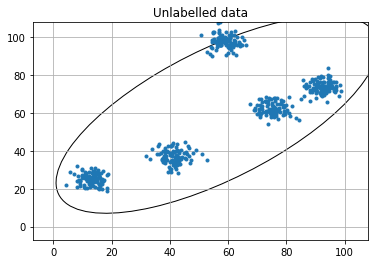

In [402]:
dimensions = 2
nclusters = 5
covariance =  10
npoints = 100
minRange = 10
maxRange = 100

dataset = createData(nclusters, dimensions, covariance, npoints, 
                                              minRange=minRange, maxRange=maxRange, labelled = False)
#dataset=dataset[:,:-1]
figure, axes = plt.subplots(nrows = 1, ncols = 1)
plotData(dataset, "Unlabelled data", axes, labels=False)
plt.show()

For tree descent, we have to decide how many clusters we want to produce (limit depth) or what should be the threshold of information gain for the algorithm to stop (information gain limit)

In [403]:
root.traverse_preorder()

---------------
Tree Node: 
---------------
 split dimension: 0 
split value: 62.08 

entropy: 11.59 
mean: 51.3110400816
cov: [[ 580.78024271  -30.65609435]
 [ -30.65609435   57.38469169]]
left entropy: 10.42 
right entropy: 9.04 

node height: 0 

 left
---------------
Tree Node: 
---------------
 split dimension: 0 
split value: 33.91 

entropy: 10.42 
mean: 42.7282724827
cov: [[ 152.40387443  -47.112451  ]
 [ -47.112451     56.81103131]]
left entropy: 7.74 
right entropy: 8.62 

node height: 1 

 right
---------------
Tree Node: 
---------------
 split dimension: 1 
split value: 38.99 

entropy: 8.62 
mean: 45.4295820917
cov: [[ 10.78774853   5.37056807]
 [  5.37056807  51.52452118]]
left entropy: 7.35 
right entropy: 7.43 

node height: 2 

 right
---------------
Tree Node: 
---------------
 split dimension: 1 
split value: 39.32 

entropy: 9.04 
mean: 64.1851914801
cov: [[ 37.28258229  34.37654135]
 [ 34.37654135  57.15936018]]
left entropy: 7.30 
right entropy: 7.54 

node heigh

In [404]:
root = create_decision_tree_unlabelled(dataset, dimensions=2, clusters = nclusters, verbose=True)

/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  from ipykernel import kernelapp as app


created new node:
---------------
Tree Node: 
---------------
 split dimension: 1 
split value: 84.63 

entropy: 13.12 
mean: 57.7256661742
cov: [[ 764.17667877  498.1422221 ]
 [ 498.1422221   682.25765205]]
left entropy: 11.18 
right entropy: 7.44 

node height: 0 
None
---------------
Tree Node: 
---------------
 split dimension: 0 
split value: 52.93 

entropy: 11.18 
mean: 52.5440494492
cov: [[ 950.75917875  588.70960195]
 [ 588.70960195  383.85548849]]
left entropy: 9.80 
right entropy: 9.18 

node height: 0 
---------------
Tree Node: 
---------------
 split dimension: 0 
split value: 18.98 

entropy: 9.80 
mean: 29.1899693944
cov: [[ 211.51105904   83.80487108]
 [  83.80487108   46.0332661 ]]
left entropy: 7.22 
right entropy: 7.75 

node height: 0 
---------------
Tree Node: 
---------------
 split dimension: 0 
split value: 84.55 

entropy: 9.18 
mean: 75.8981295039
cov: [[ 83.43459067  49.70128343]
 [ 49.70128343  43.46920865]]
left entropy: 7.44 
right entropy: 7.34 

node h

In [405]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals)[np.not_equal(cut_vals,None)].astype(float)
cut_dims = np.asarray(cut_dims)[np.not_equal(cut_dims,None)].astype(int)

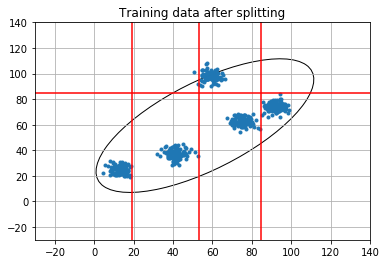

In [406]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

fig, ax = plt.subplots(1,1)
plotData(dataset, "Training data after splitting", ax, labels=False, linesX = x_split, linesY = y_split, 
                            minRange = minRange, maxRange = maxRange, covariance=covariance)

%clear
plt.show()

In [407]:
print(cut_dims, cut_vals)

[1 0 0 0] [ 84.63439885  52.93448459  18.98104862  84.55025488]


# Printing the Tree

In [420]:
def print_rule(node):
    """Helper function to print the split decision of a given node"""
    rule_string = str(node.split_dimension) + "$<$" + str(np.round(node.split_value, 1))
    return rule_string


def print_density_tree_latex(node, tree_string):
    """print decision tree in a LaTeX syntax for visualizing the decision tree
    To be called as:
    tree_string = ""
    tree_string = printstuff(root,tree_string)
    """
    tree_string += "["

    tree_string += print_rule(node)
    #print(tree_string)
    print_rule(node)

    # check if node is leaf node
    if node.left is None:
        tree_string += "[ent:%.2f]"  % node.left_entropy
    # check if node is leaf node
    if node.right is None:
        tree_string += "[ent:%.2f]"  % node.right_entropy

    # iterate over node's children
    if node.left is not None:
        tree_string = print_density_tree_latex(node.left, tree_string)

    if node.right is not None:
        tree_string = print_density_tree_latex(node.right, tree_string)
    tree_string += "]"

    return tree_string

In [421]:
tree_string = ""
tree_string = print_density_tree_latex(root,tree_string)
tree_string

'[1$<$84.6[ent:7.44][0$<$52.9[0$<$19.0[ent:7.22][ent:7.75]][0$<$84.6[ent:7.44][ent:7.34]]]]'

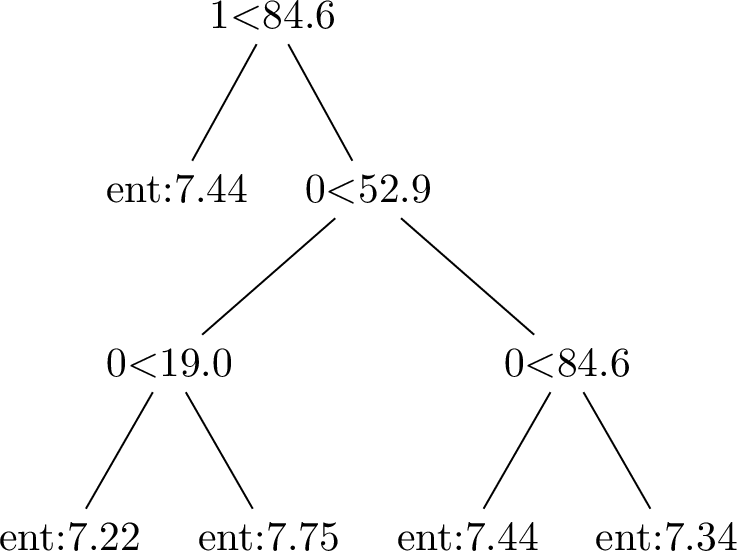

In [422]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root,tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; /Library/TeX/texbin/pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)